In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from algo import AdaFair, AdaBoost, SMOTEBoost, SMOTEBoostProtected, AdaFairCorrect, RUSBoost
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from utils import get_dataset
from metrics import calculate_metrics

In [2]:
dataset_list = [
    'adult',
    'bank',
    'compass',
    'kdd',
]
algorithms = [
    AdaBoost,
    AdaFair,
    SMOTEBoost,
    RUSBoost,
    LogisticRegression
]
train_metrics, test_metrics = {}, {}

for dataset in tqdm(dataset_list):
    print(f'Dataset {dataset}')
    
    X_train, y_train, is_protected_train, X_test, y_test, is_protected_test = get_dataset(dataset, test_size=0.25)
    
    print(f'Train size: {X_train.shape}, Test size: {X_test.shape}')
    print(f'Positive ratio (train): {y_train.mean():.3f}, Positive ratio (test): {y_test.mean():.3f}')
    print(f'Protected ratio (train): {is_protected_train.mean():.3f}, Protected ratio (test): {is_protected_test.mean():.3f}')
    
    for model_class in tqdm(algorithms, position=1, leave=False):
        if model_class.__name__ == 'AdaFair' and (dataset == 'compass' or dataset == 'kdd'):
            model = model_class(n_estimators=50, u_weight=1)
            model.fit(X_train, y_train, is_protected_train)
        elif model_class.__name__ == "LogisticRegression":
            sm = SMOTE(random_state=42)
            X_res, y_res = sm.fit_resample(X_train, y_train)
            
            model = model_class(class_weight="balanced")
            model.fit(X_res, y_res)
        else:
            model = model_class()
            model.fit(X_train, y_train, is_protected_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_metrics[dataset, model_class.__name__] = calculate_metrics(y_train, y_train_pred, is_protected_train)
        test_metrics[dataset, model_class.__name__] = calculate_metrics(y_test, y_test_pred, is_protected_test)
    
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

Dataset adult
Train size: (36631, 108), Test size: (12211, 108)
Positive ratio (train): 0.239, Positive ratio (test): 0.239
Protected ratio (train): 0.332, Protected ratio (test): 0.332


  0%|          | 0/5 [00:00<?, ?it/s]


Dataset bank
Train size: (33908, 51), Test size: (11303, 51)
Positive ratio (train): 0.117, Positive ratio (test): 0.117
Protected ratio (train): 0.602, Protected ratio (test): 0.602


  0%|          | 0/5 [00:00<?, ?it/s]


Dataset compass
Train size: (4629, 11), Test size: (1543, 11)
Positive ratio (train): 0.455, Positive ratio (test): 0.455
Protected ratio (train): 0.190, Protected ratio (test): 0.191


  0%|          | 0/5 [00:00<?, ?it/s]


Dataset kdd
Train size: (224463, 409), Test size: (74822, 409)
Positive ratio (train): 0.062, Positive ratio (test): 0.062
Protected ratio (train): 0.520, Protected ratio (test): 0.520


  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
test_metrics

{('adult', 'AdaBoost'): {'Accuracy': 0.8565228073048891,
  'Bal. Acc.': 0.7685845732910409,
  'Eq.Odds': 0.23266361806899022,
  'TPR Prot.': 0.4660633484162896,
  'TPR Non-Prot.': 0.6237903225806452,
  'TNR Prot.': 0.983083749306711,
  'TNR Non-Prot.': 0.9081471054020763},
 ('adult', 'AdaFair'): {'Accuracy': 0.8190975350094177,
  'Bal. Acc.': 0.7889071063497639,
  'Eq.Odds': 0.1163454561575729,
  'TPR Prot.': 0.7330316742081447,
  'TPR Non-Prot.': 0.7306451612903225,
  'TNR Prot.': 0.9165280088740987,
  'TNR Non-Prot.': 0.802569065634348},
 ('adult', 'SMOTEBoost'): {'Accuracy': 0.8513635246908525,
  'Bal. Acc.': 0.7602673457208629,
  'Eq.Odds': 0.17570408570516435,
  'TPR Prot.': 0.49547511312217196,
  'TPR Non-Prot.': 0.6016129032258064,
  'TNR Prot.': 0.9775374376039934,
  'TNR Non-Prot.': 0.9079711420024635},
 ('adult', 'RUSBoost'): {'Accuracy': 0.8241749242486283,
  'Bal. Acc.': 0.8297767284009429,
  'Eq.Odds': 0.3088832133765138,
  'TPR Prot.': 0.7420814479638009,
  'TPR Non-Prot.

test metrics:


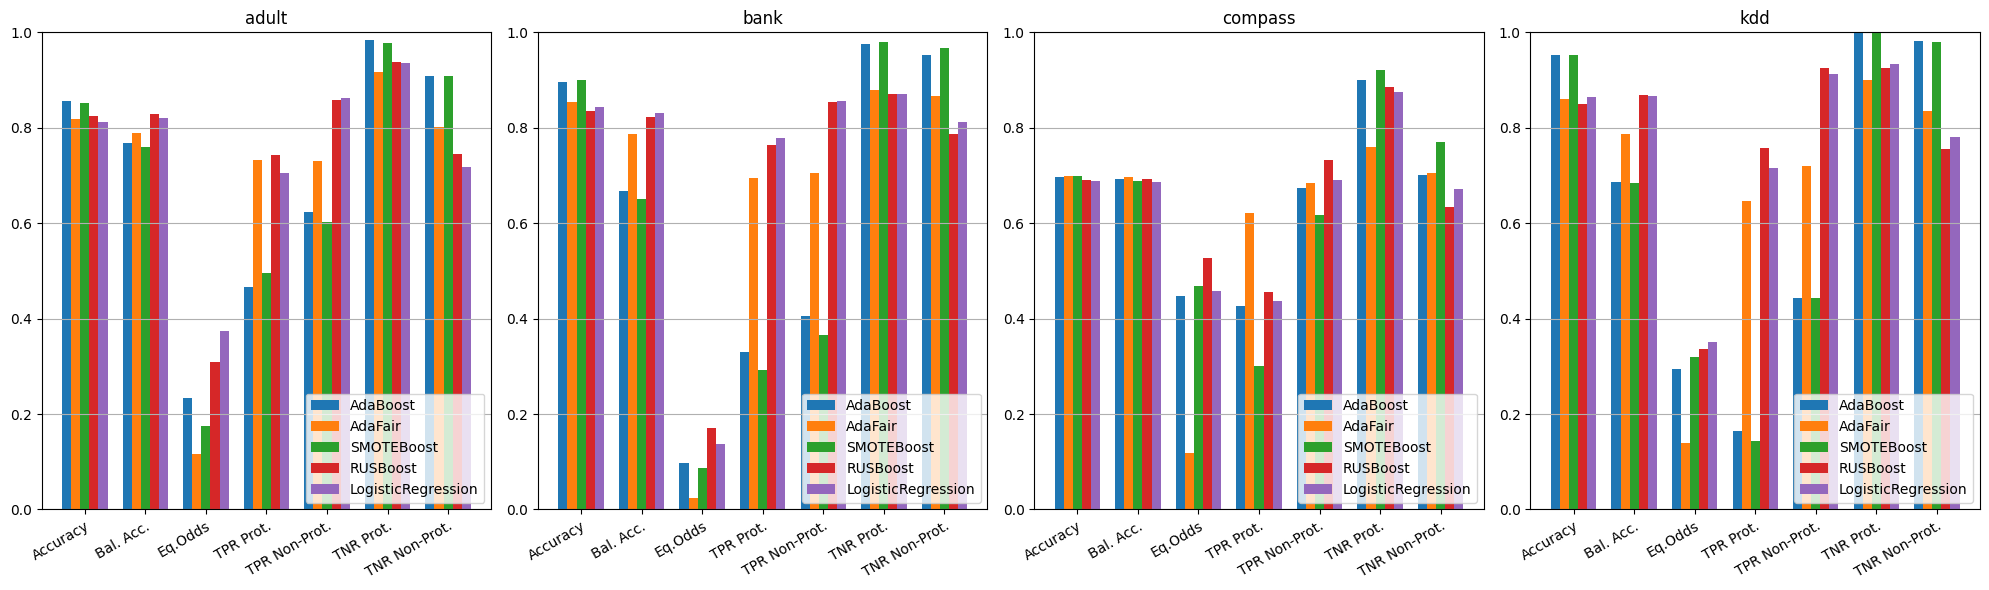

train metrics:


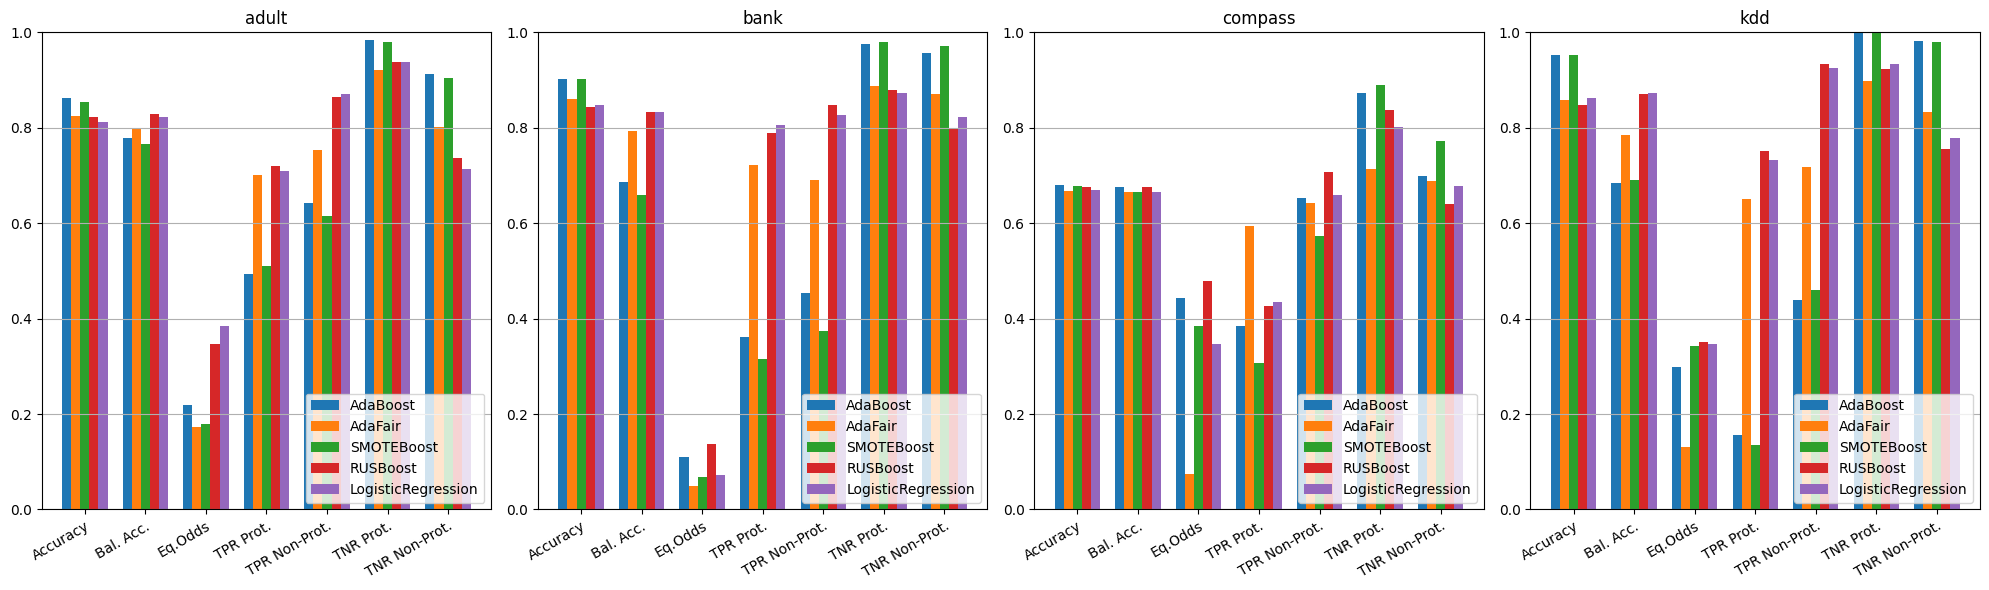

In [8]:
def plot_metrics(ax, metrics, dataset):
    metric_names = metrics[dataset, algorithms[0].__name__].keys()
    x = np.arange(len(metric_names))
    width = 0.15  # the width of the bars
    ax.yaxis.grid()
    for i, algo in enumerate(algorithms):
        algo_name = algo.__name__
        measurement = [metrics[dataset, algo_name][m] for m in metric_names]
        rects = ax.bar(x + width * i, measurement, width, label=algo_name)
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')
    ax.set_xticks(x + width * (len(algorithms) - 1) / 2, metric_names, rotation=30,
                  rotation_mode="anchor", horizontalalignment='right', verticalalignment='top')

for metrics, name in [(test_metrics, 'test'), (train_metrics, 'train')]:
    _, axes = plt.subplots(1, len(dataset_list), figsize=(20, 6))
    if len(dataset_list) == 1:
        axes = [axes]
    print(name, 'metrics:')
    for dataset, ax in zip(dataset_list, axes):
        plot_metrics(ax, metrics, dataset)
        ax.set_title(dataset)
    plt.tight_layout()
    plt.show()